# SNR Bound

Simulated and theoretical signal-to-noise ratio as a function of self-interference

## Setup

In [1]:
from IPython.display import display, Markdown

import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# For link-level simulations
from sionna.channel import AWGN, ApplyOFDMChannel, time_to_ofdm_channel
from sionna.ofdm import OFDMModulator, ResourceGrid, ResourceGridMapper
from sionna.nr import CarrierConfig
from sionna.utils import QAMSource
from sionna.signal import fft

from cissir.adc import max_abs_complex, papr, quantize_signal, snr_thermal, sqnr_bound
from cissir.beamforming import Beamspace, sionna_mimo_axes
from cissir.utils import plot_path, res_path
from cissir.raytracing import load_cir, load_si_paths, normalize_si_taps

import pandas as pd
import seaborn as sns

from cissir import physics as phy, params, optimization as opt, visualization as viz
viz.paper_style()

import itertools
from tqdm.notebook import tqdm


In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

Q_bits = 6 # Each complex component (I and Q) is quantized with Q bits

In [3]:
## Waveform params

c_config = CarrierConfig(subcarrier_spacing=params.subcarrier_spacing_khz,
                         cyclic_prefix="normal")
num_subcarriers = params.num_prb * params.subcarriers_per_rb
subcarrier_spacing = params.subcarrier_spacing_khz * 1e3

Ts_sec = c_config.t_c
fft_size = round(1e-3/(c_config.subcarrier_spacing * Ts_sec))
cyclic_prefix_length = round(c_config.cyclic_prefix_length/Ts_sec)
digital_bw_hz = 1/Ts_sec

sig_bw_hz = num_subcarriers * subcarrier_spacing
sig_bw_frac = num_subcarriers/fft_size

t_channel_s = tf.range(cyclic_prefix_length, dtype=tf.float64) * Ts_sec
distance_m = phy.delay2distance(t_channel_s)

## OFDM configuration
num_ofdm_symbols = 1 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
pilot_pattern = None # Pilot pattern
pilot_ofdm_symbol_indices = None # Index of OFDM symbols carrying pilots

null_carriers = fft_size - num_subcarriers
num_guard_carriers = [null_carriers//2, null_carriers//2] # Number of guard carriers on each side

rg = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                 fft_size = fft_size,
                 subcarrier_spacing = subcarrier_spacing,
                 num_tx = 1,
                 num_streams_per_tx = 1,
                 cyclic_prefix_length = cyclic_prefix_length,
                 dc_null = dc_null,
                 pilot_pattern = pilot_pattern,
                 pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                 num_guard_carriers = num_guard_carriers)

### Beam codebook


In [4]:
with np.load(res_path/"phased_cissir_codebooks.npz") as cb_data:
    opt_si = cb_data["si_opt"]
    tgt_si = cb_data["si_tgt"]
    si_points = len(opt_si)
    
    opt_tx_codebooks = cb_data["tx"]
    L_t = opt_tx_codebooks.shape[-1]
    assert opt_tx_codebooks.shape == (si_points, N_t, L_t), "Unexpected shape for Tx codebook"
    opt_rx_codebooks = cb_data["rx"]
    L_r = opt_rx_codebooks.shape[-1]
    assert opt_rx_codebooks.shape == (si_points, N_r, L_r), "Unexpected shape for Tx codebook"

    tx_degs = cb_data["tx_degrees"]
    rx_degs = cb_data["rx_degrees"]
    beam_degs = tx_degs
    
    tx_codebook_p = opt_tx_codebooks[0,]
    rx_codebook_p = opt_rx_codebooks[0,]

In [5]:
tx_cb_matrix = tf.cast(tx_codebook_p, dtype=tf.complex64)  # (N_t, L_t)
rx_cb_matrix = tf.cast(rx_codebook_p, dtype=tf.complex64)  # (N_r, L_r)

### Backscatter channels 

In [6]:
si_num_taps = "full"   # Options: 1, 2, "full"

ht_tgt, ht_si = load_cir('ht_tgt', 'ht_si', tf_type=tf.complex64)
t_rt = load_cir('t_channel_s', tf_type=None)

assert tf.math.reduce_all(tf.equal(t_rt, t_channel_s)), "Wrong assumed time scale from simulations"

if isinstance(si_num_taps, int):
    h_si_paths, t_paths = load_si_paths(num_taps=si_num_taps)
    h_si_paths, _ = normalize_si_taps(h_si_paths, ht_si,
                                      tx_codebook_p, rx_codebook_p)
    t_arg = np.argmin(np.abs(t_rt - t_paths).squeeze(), axis=-1, keepdims=True)
    ht_si = np.zeros_like(ht_si)[:si_num_taps,]
    for i, ta in enumerate(t_arg):
        ht_si[i, ..., ta] = h_si_paths[i,].reshape(ht_si[i,..., ta].shape)
elif si_num_taps != "full":
    raise ValueError("Invalid SI tap option")
    
h_mimo = tf.concat([ht_si, ht_tgt], axis=0)
h_mimo.shape

TensorShape([3, 1, 8, 1, 8, 1, 2176])

In [7]:
# Beam forming
rx_axis, tx_axis = sionna_mimo_axes("ofdm")
opt_beamspace = Beamspace(receive_axis=rx_axis, transmit_axis=tx_axis)
h_siso = opt_beamspace([h_mimo, rx_cb_matrix, tx_cb_matrix])
h_beams = tf.squeeze(h_siso, axis=(1, 3, 5))
h_beams = tf.transpose(h_beams, perm=[0, 3, 1, 2])
h_beams = tf.linalg.diag_part(h_beams)

In [8]:
l_max = tf.argmax(tf.reduce_max(tf.abs(h_beams[-1,]), axis=0))
t_argmax = tf.argmax(tf.reduce_max(tf.abs(h_beams[-1,]), axis=1))
dist_tgt = distance_m[t_argmax]
az_tgt = beam_degs[l_max]
dist_max = dist_tgt + 5
print(f"Target located at {dist_max:.1f} m, {az_tgt:.1f}°")

Target located at 44.7 m, -38.7°


In [9]:
hf_list = []
opt_tx_beam = opt_tx_codebooks[..., l_max:l_max+1]
opt_rx_beam = opt_rx_codebooks[..., l_max:l_max+1]
for i in range(si_points):
    tx_cb_vec = tf.cast(opt_tx_beam[i,], dtype=tf.complex64)
    rx_cb_vec = tf.cast(opt_rx_beam[i,], dtype=tf.complex64)
    h_siso = opt_beamspace([h_mimo, rx_cb_vec, tx_cb_vec])
    h_b = tf.squeeze(h_siso, axis=(1, 3, 5))
    h_b = tf.transpose(h_b, perm=[0, 3, 1, 2])
    h_b = tf.linalg.diag_part(h_b)
    ht_ = h_b[..., 0]

    hfreq = time_to_ofdm_channel(tf.reshape(ht_, shape=(1, ht_.shape[0], 1, 1, 1, 1, ht_.shape[-1])) * 
                             tf.ones(shape=(1, 1, 1, 1, 1, fft_size+cyclic_prefix_length, ht_.shape[-1]),
                                     dtype=ht_.dtype), rg, l_min=0)
    hf_list.append(hfreq)

In [10]:
hfreq_opt = tf.stack(hf_list, axis=0)

In [11]:
si_beam = []
tx_dev = []
h_si_beam = np.squeeze(np.sum(ht_si, axis=0)).transpose(2, 0, 1)
tx_ref = opt_tx_beam[0]
for i in range(si_points):
    si_b = opt.codebook_si(opt_tx_beam[i], opt_rx_beam[i,], h_si_beam)
    si_beam.append(phy.mag2db(np.max(si_b)))
    tx_d = opt.codebook_deviation_power(opt_tx_beam[i], tx_ref)
    tx_dev.append(phy.pow2db(max(tx_d, 1e-10)))

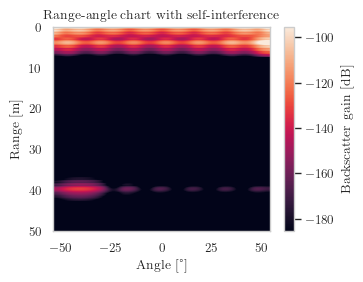

In [12]:
min_dist_m = 0
max_dist_m = 50

dr_db = 90

h_beams_db = phy.mag2db(tf.abs(np.sum(h_beams, axis=0)) + 1e-20)

vmax = np.quantile(h_beams_db, 0.998)
vmin = vmax - dr_db

extent = (min(beam_degs), max(beam_degs), min(distance_m), max(distance_m))
plt.imshow(h_beams_db, vmin=vmin, vmax=vmax, interpolation='bicubic',
           origin='lower', extent=extent, aspect="auto"),
plt.xlabel("Angle [°]")
plt.ylabel("Range [m]")
plt.xlim(extent[1], extent[0])
plt.ylim(min_dist_m, max_dist_m)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.grid(visible=False)
cbar = plt.colorbar()
cbar.set_label("Backscatter gain [dB]")
_ = plt.title("Range-angle chart with self-interference")

In [13]:
ht = h_beams[..., l_max]
hfreq = time_to_ofdm_channel(tf.reshape(ht, shape=(1, ht.shape[0], 1, 1, 1, 1, ht.shape[-1])) * 
                             tf.ones(shape=(1, 1, 1, 1, 1, fft_size+cyclic_prefix_length, ht.shape[-1]),
                                     dtype=ht.dtype), rg, l_min=0)

hr1 = tf.abs(tf.norm(ht[-1,], ord=1))
hr2 = tf.abs(tf.norm(ht[-1,], ord=2))
hs1_init = tf.abs(tf.norm(ht[0,], ord=1))
t_vec = t_channel_s * 1e6

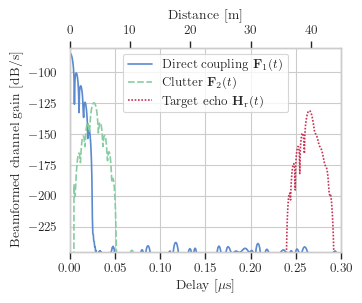

In [14]:
tmin_us = 0
tmax_us = 0.3

ymin, ymax = -245, -80

t_complex = tf.cast(t_vec, dtype=ht.dtype)
tmean_si = tf.cast(tf.norm(t_complex * ht[0,], ord=1)/hs1_init, dtype=t_vec.dtype)
tmean_r = tf.cast(tf.norm(t_complex * ht[-1,], ord=1)/hr1, dtype=t_vec.dtype)

h_df =pd.DataFrame(phy.mag2db(np.abs(ht)).squeeze().T, columns=["hsi1", "hsi2", "hr"], index=distance_m)
h_df["hr"] = np.where(distance_m > 20, h_df["hr"], -500)
h_df["hsi2"] = np.where(distance_m > 0.65, h_df["hsi2"], -500)

fig, ax = plt.subplots()

ax.set_xlim(tmin_us, tmax_us)
ax.set_ylim(ymin, ymax)

ax.set_xlabel("Delay [$\mu$s]")
ax.set_ylabel("Beamformed channel gain [dB/s]")

ax2 = ax.twiny()
ax2.set_xlim(phy.delay2distance(tmin_us * 1e-6), phy.delay2distance(tmax_us * 1e-6))
ax2.set_ylim(ymin, ymax)
ax2.set_xlabel("Distance [m]")
ax2.grid(visible=False)

sns.lineplot(h_df, palette=[viz.b, viz.g, viz.r], ax=ax2)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, ["Direct coupling $\mathbf{F}_1(t)$",
                     "Clutter $\mathbf{F}_2(t)$",
                     "Target echo $\mathbf{H}_\mathrm{r}(t)$"],)
                     # loc="lower center", bbox_to_anchor=(0.45, 0.05))

h_df = h_df.reindex(distance_m)
fig.savefig(plot_path/"sensing_channel.pgf", bbox_inches="tight")

## Simulations

In [15]:
symbol_energy = 1.0
noise_power = params.n0 * sig_bw_hz # mW
ch_gain = hr2**2/sig_bw_frac
noise_dbm = phy.pow2db(noise_power)
channel_db = phy.pow2db(ch_gain)
si_db_init = phy.mag2db(hs1_init)

pt_dbm = 30
papr_ref = 2.0 

snr_th_db = pt_dbm + phy.pow2db(ch_gain) - noise_dbm

link_display = ["### Link budget summary\n", f"| Parameter | Value | Unit | Condition |",
                f"| --------- | -----: | ---- | ---------: |", f"| $P_t$ level | {pt_dbm} | dBm | |",
                f"| SI gain | {si_db_init:.1f} | dB | |", f"| Channel gain | {channel_db:.1f} | dB | |",
                f"| Noise power | {noise_dbm:.1f} | dBm | |",
                f"| Thermal SNR | {snr_th_db:.1f} | dB | $P_t$={pt_dbm} dBm |"]

channel_db = phy.mag2db(hr1)
sqnr_db = phy.pow2db(sqnr_bound(si_db_init - channel_db, hr1, hr2,
                                Q_bits, papr_ref, 1.0, sig_bw_frac, None))
link_display.append(f"| ADC SNR | {sqnr_db:.1f} | dB | PAPR={phy.pow2db(papr_ref):.1f} dB |")
display(Markdown("\n".join(link_display)))

si_values = np.arange(10 * round(channel_db/10) + 10, si_db_init + 20, 3.5)

        # {"waveform_name": (bits_per_symbol, dft_spread), ...}
wf_dict = {"QPSK SC-FDM": (2, True),
           "64QAM  OFDM": (6, False)}

waveforms = tuple(wf_dict.keys())

trials = 1000

### Link budget summary

| Parameter | Value | Unit | Condition |
| --------- | -----: | ---- | ---------: |
| $P_t$ level | 30 | dBm | |
| SI gain | -66.6 | dB | |
| Channel gain | -111.0 | dB | |
| Noise power | -90.8 | dBm | |
| Thermal SNR | 9.8 | dB | $P_t$=30 dBm |
| ADC SNR | -9.6 | dB | PAPR=3.0 dB |

In [16]:
si_min, si_max = -106, -59

si_index = np.arange(len(tgt_si))[np.logical_and(si_min < opt_si, opt_si < si_max)]
ofdm_channel = ApplyOFDMChannel(add_awgn=False)
awgn = AWGN()

In [17]:
progress_bar = tqdm(itertools.product(waveforms, si_index), total=len(waveforms)*len(si_index))
simulation_log = []
for wf_k, si_i in progress_bar:

    si_db = tgt_si[si_i]
    
    num_bits_per_symbol, dft_spread = wf_dict[wf_k]

    g_t = np.sqrt(phy.db2power(pt_dbm) / (symbol_energy * sig_bw_frac))
    
    
    console_out = [f"{wf_k}, Pt {pt_dbm} dBm\tSI {si_db:.1f} dB"]

    hf = hfreq_opt[si_i]
    # Modulation order 
    qam_source = QAMSource(num_bits_per_symbol =  num_bits_per_symbol) 
    
    # symbols onto an OFDM resource grid
    rg_mapper = ResourceGridMapper(rg)
    
    # OFDM modulator: freq --> time
    modulator = OFDMModulator(rg.cyclic_prefix_length)
    
    batch_size = trials
    
    # Binary source + QAM mapper block 
    x_symbols = qam_source([batch_size, 1,1, rg.num_data_symbols])
    
    # Resource grid mapper block 
    x_rg = g_t * rg_mapper(x_symbols)
    
    if dft_spread:
        guard_shape = tf.concat([x_rg.shape[:-1], tf.constant([null_carriers//2])], axis=0)
        zero_carriers = tf.zeros(shape=guard_shape, dtype=x_rg.dtype)
        dft_start, dft_end = null_carriers//2, null_carriers//2 + num_subcarriers
        x_dft = fft(x_rg[..., dft_start:dft_end])
        x_rg = tf.concat([zero_carriers, x_dft, zero_carriers], axis=-1)

    x_t = modulator(x_rg)

    y_freq = ofdm_channel([x_rg, hf])
    y_time = modulator(y_freq)
    y_si, y_r = y_time[:,0,], y_time[:,-1,] 
    y_t = y_r + y_si
    y_n = awgn([y_t, noise_power])
    
    pow_yr = tf.math.reduce_variance(y_r, axis=tf.range(1, y_r.ndim))
    
    pow_xr = tf.math.reduce_variance(x_t, axis=tf.range(1, x_t.ndim))
    max_yn = max_abs_complex(y_n, axis=tf.range(1, y_t.ndim), keepdims=True)
    yn_quant = quantize_signal(y_n, max_value=max_yn, quantization_bits=Q_bits)
    
    quant_err_y = yn_quant - y_t
    
    alpha = pow_yr /(pow_xr*hr2**2 / sig_bw_frac)
    console_out.append(f"Ratio alpha {tf.reduce_mean(alpha):.2f}")
    
    papr_x = papr(x_t, axis=tf.range(1,x_t.ndim))
    q_err_measured = tf.math.reduce_variance(quant_err_y, axis=tf.range(1, y_t.ndim))

    if noise_power > 0:
        snr_pow = snr_thermal(phy.db2power(pt_dbm), noise_power=noise_power,
                              channel_gain=ch_gain) 
    else:
        snr_pow = None
  
    
    sq_theoretic = tf.reduce_mean(sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alpha, sig_bw_frac, snr_pow))
    sq_measured = tf.reduce_min(pow_yr/q_err_measured)
    console_out.append(f"Min.SQNR (bound | measure): { phy.pow2db(sq_theoretic):.1f} | { phy.pow2db(sq_measured):.1f} dB")
    
    progress_bar.set_description_str("; ".join(console_out))
    
    simulation_log.append({"si_db": si_db, "si_index": si_i, "waveform": wf_k, "pt_dbm": pt_dbm,
                           "sig_bw": sig_bw_hz, "alpha": alpha.numpy(), "pow_xr": pow_xr.numpy(), "max_y": max_yn.numpy().squeeze(),
                           "papr_x": papr_x.numpy(), "pow_yr": pow_yr.numpy(), "q_err": q_err_measured.numpy()})

sim_df = pd.DataFrame(simulation_log).explode(column=["alpha", "pow_xr", "papr_x", "pow_yr", "q_err", "max_y"])
sim_df.to_csv(res_path/"sqnr_results.csv")

  0%|          | 0/92 [00:00<?, ?it/s]

## Plots

In [18]:
sim_df = pd.read_csv(res_path/"sqnr_results.csv", index_col=0)
sim_df

,si_db,si_index,waveform,pt_dbm,sig_bw,alpha,pow_xr,max_y,papr_x,pow_yr,q_err
0,-59.487686,6,QPSK SC-FDM,30,201600000.0,0.994698,998.76220,0.027844,5.942179,7.901885e-09,1.274348e-07
0,-59.487686,6,QPSK SC-FDM,30,201600000.0,0.988577,998.92114,0.023069,3.960185,7.854514e-09,8.783228e-08
0,-59.487686,6,QPSK SC-FDM,30,201600000.0,0.993305,999.56915,0.026245,5.177746,7.897195e-09,1.123796e-07
0,-59.487686,6,QPSK SC-FDM,30,201600000.0,0.992272,998.75940,0.024640,4.483434,7.882589e-09,9.981762e-08
0,-59.487686,6,QPSK SC-FDM,30,201600000.0,0.980584,999.40515,0.023463,4.284802,7.794784e-09,9.133393e-08
...,...,...,...,...,...,...,...,...,...,...,...
91,-104.487686,51,64QAM OFDM,30,201600000.0,0.767578,1035.22070,0.000332,9.623143,6.320227e-09,8.433599e-10
91,-104.487686,51,64QAM OFDM,30,201600000.0,0.782519,1029.36630,0.000347,9.525167,6.406814e-09,8.554255e-10
91,-104.487686,51,64QAM OFDM,30,201600000.0,0.782680,979.92880,0.000336,11.216292,6.100368e-09,8.582543e-10
91,-104.487686,51,64QAM OFDM,30,201600000.0,0.767335,995.00250,0.000351,8.696220,6.072765e-09,8.539233e-10


In [19]:
sig_bw, pow_xr = sim_df[["sig_bw", "pow_xr"]].mean().values
alpha = sim_df.groupby(["si_index"])["alpha"].mean()
papr_s = sim_df.groupby(["waveform"])["papr_x"].mean()
avg_val_q = sim_df[["waveform", "si_db", "pow_yr", "q_err", "pt_dbm"]]

In [20]:
bnd_label = "High-SI bound"
ach_label = "Real bound"
sim_label = "Simulation"
wf_label = "Waveform    (avg PAPR)"
pt_label = "Tx Power"


alph_theory = np.max(alpha)
theory_collector = []
achieved_collector = []
wf_params = {}
for wf in waveforms:
    papr_x = papr_s[wf]
    sig_bw_frac = sig_bw/digital_bw_hz
    wf_params[wf] = f"/{phy.pow2db(papr_x):.1f}dB"
    if noise_power > 0:
        snr_pow = snr_thermal(phy.db2power(pt_dbm) * alph_theory, noise_power=noise_power, channel_gain=ch_gain) 
    else:
        snr_pow = None
    for si_db in np.linspace(si_min, si_max, 1000):
        sqnr_theory = sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alph_theory, sig_bw_frac, snr_pow)
        sqnr_pure = sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alph_theory, sig_bw_frac, None)
        theory_collector.append({"type": bnd_label, "waveform": wf, "pt_dbm": pt_dbm, "si_db": si_db, "sqnr_db": phy.pow2db(sqnr_theory), "sqr": phy.pow2db(sqnr_pure)})
    for si_i in si_index:
        eps_si = tgt_si[si_i]
        si_db = si_beam[si_i]
        alph_si = alpha.loc[si_i]
        snr_pow = snr_thermal(phy.db2power(pt_dbm) * alph_si, noise_power=noise_power, channel_gain=ch_gain)
        
        sqnr_achieved = sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alph_si, sig_bw_frac, snr_pow)
        achieved_collector.append({"type": ach_label, "waveform": wf, "pt_dbm": pt_dbm, "si_db": eps_si, "sqnr_db": phy.pow2db(sqnr_achieved)})

In [21]:
alph_theory

0.98698313909

In [22]:
bnd_df = pd.DataFrame(achieved_collector+theory_collector).reset_index()

In [23]:
empiric_df = avg_val_q.reset_index()
empiric_df["type"] = sim_label
empiric_df["sqnr_db"] = phy.pow2db(empiric_df["pow_yr"] / empiric_df["q_err"])

In [24]:
plot_df = pd.concat([empiric_df, bnd_df], axis=0).reset_index()
plot_df[pt_label] = plot_df["pt_dbm"].apply(str) + " dBm" 
plot_df[wf_label] = plot_df["waveform"] + plot_df["waveform"].map(wf_params)

si_gains = plot_df["si_db"]
plot_df["si_gain"] = si_gains
si_gains = si_gains.unique()

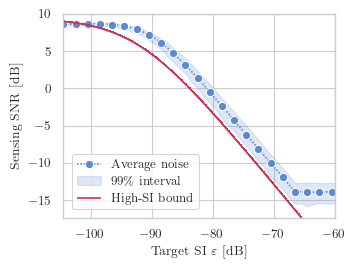

In [25]:
wf_plot = waveforms[-1]

fig, ax2 = plt.subplots(1,1)

xlims = (empiric_df["si_db"].min(), -60) # empiric_df["si_db"].min(), empiric_df["si_db"].max()
ylims = (bnd_df.query(f"type == '{ach_label}' and  waveform =='{wf_plot}'")["sqnr_db"].min() - 1,
         10) #plot_df.sqnr_db.max()+0.5)

ln_order = style_order = [sim_label, bnd_label] # ach_label

sns.lineplot(plot_df.query(f" waveform =='{wf_plot}' and type != '{ach_label}'"), x="si_gain", y="sqnr_db", style="type", style_order=ln_order,
             hue_order=ln_order, estimator=phy.avg_snr_noise,
             markers=["o", ","], dashes=((1,1), (1,0)),
             errorbar=("pi", 98),
             hue="type", markevery=2, markersize=6, palette=[viz.b, viz.r],
             ax=ax2)

ax2.collections[0].set_label('pi')
ax2.legend()
handles, _ = ax2.get_legend_handles_labels()
ax2.legend(handles[1::-1] + handles[::-1], [r"Average noise", r"99\% interval", "High-SI bound"],
           loc="lower left", borderaxespad=0.7)

plt.sca(ax2)
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel(r"Target SI $\varepsilon$ [dB]")
plt.ylabel("Sensing SNR [dB]")

fig.savefig(plot_path/"bound_sqnr.pgf", bbox_inches="tight")
fig.savefig(plot_path/"bound_sqnr.pdf", bbox_inches="tight")

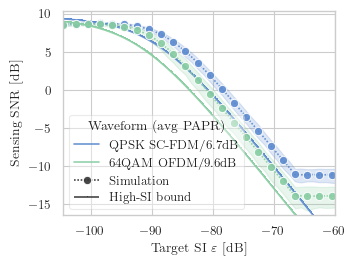

In [26]:
fig, ax2 = plt.subplots(1,1)
plot_title = f"SQNR vs. Self-interference (Bandwidth: {sig_bw_hz*1e-6:.1f} MHz @ {fc*1e-9} GHz)"

xlims = (empiric_df["si_db"].min(), -60)
ylims = (bnd_df.query(f"type == '{ach_label}'")["sqnr_db"].min(),
         plot_df.sqnr_db.max() + 1)

ln_order = [sim_label, bnd_label]

sns.lineplot(plot_df.query(f"type != '{ach_label}'"), x="si_gain", y="sqnr_db", style="type", style_order=ln_order,
             estimator=phy.avg_snr_noise,
             alpha=0.9,
             markers=["o", ","], dashes=((1,1), (1,0)),
             errorbar=("pi", 98),
             hue=wf_label, markevery=2, markersize=6, palette=[viz.b, viz.g],
             ax=ax2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[1:3]+handles[-2:], labels[1:3]+labels[-2:], title=wf_label, framealpha=0.4)

plt.sca(ax2)
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel(r"Target SI $\varepsilon$ [dB]")
plt.ylabel("Sensing SNR [dB]")

wf_plot = waveforms[0]
title_wf = wf_plot

fig.savefig(plot_path/"bound_sqnr_wf.pgf", bbox_inches="tight")
fig.savefig(plot_path/"bound_sqnr_wf.pdf", bbox_inches="tight")